### sampling cos(stellar inclination) given the data for stellar radius and rotation period using jax and numpyro

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import R_sun

In [5]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['savefig.dpi']=200

In [6]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
import jax.random as random

In [7]:
v_unit = (2*np.pi*R_sun.value/86400.)*1e-3
def model(vsini, sigma_vsini, rad, sigma_rad, prot, sigma_prot):
    cosi = numpyro.sample("cosi", dist.Uniform(0,1))
    rad = numpyro.sample("rad", dist.TruncatedNormal(loc=rad, scale=sigma_rad, low=0.))
    prot = numpyro.sample("prot", dist.TruncatedNormal(loc=prot, scale=sigma_prot, low=0.))
    vsini_model = v_unit * jnp.sqrt(1.-cosi**2) * rad / prot
    numpyro.deterministic("vsini", vsini_model)
    numpyro.sample("obs", dist.Normal(loc=vsini_model, scale=sigma_vsini), obs=vsini)

In [8]:
# Kepler-1627A parameters from Bouma+(2021)
vsini, sigma_vsini = 18.9, 1.0
rad, sigma_rad = 0.881, 0.881*0.04   # Tayar+2020
prot, sigma_prot = 2.642, 2.642*0.05 # Angus+2019; scatter in Praesepe

In [9]:
kernel = numpyro.infer.NUTS(model)

In [13]:
n_sample = 5000
mcmc = numpyro.infer.MCMC(kernel, num_warmup=n_sample, num_samples=n_sample)

In [14]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, vsini, sigma_vsini, rad, sigma_rad, prot, sigma_prot)

sample: 100%|██████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1913.38it/s, 7 steps of size 5.62e-01. acc. prob=0.86]


In [16]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      cosi      0.16      0.11      0.15      0.00      0.33   2532.11      1.00
      prot      2.52      0.11      2.52      2.33      2.69   2984.31      1.00
       rad      0.91      0.03      0.91      0.85      0.96   2930.58      1.00

Number of divergences: 0


In [17]:
samples = pd.DataFrame(data=mcmc.get_samples())
#save samples 
#samples.to_csv("posterior_samples.csv", index=False)

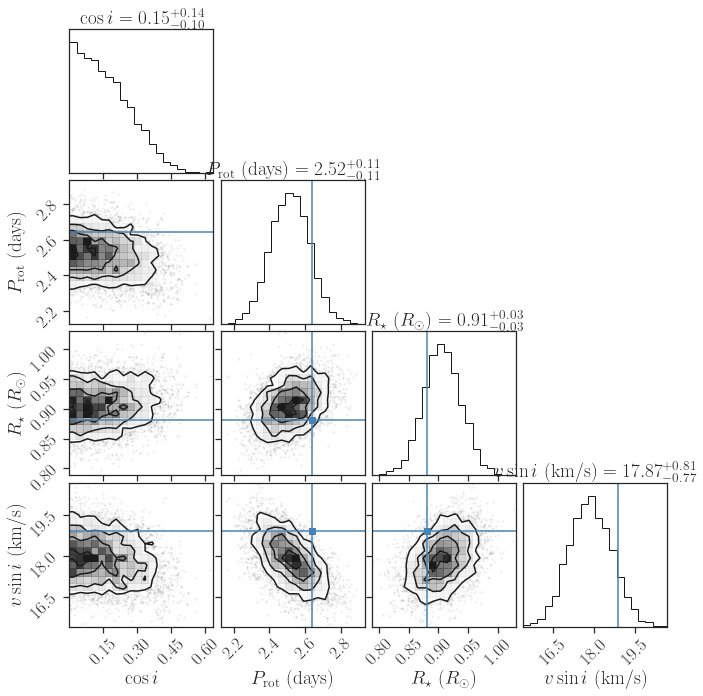

In [18]:
import corner
fig = corner.corner(samples, show_titles=True, truths=[None, prot, rad, vsini], 
                   labels=["$\cos i$", "$P_\mathrm{rot}$ (days)", "$R_\star$ ($R_\odot$)", "$v\sin i$ (km/s)"]
                   )
#fig.savefig("posterior_corner.png", bbox_inches="tight")